# Explore here


In [1]:
import torch

if torch.cuda.is_available():
    print("✅ GPU is available to Torch")
    print(f"GPU name: {torch.cuda.get_device_name(0)}")
    print(f"GPU name: {torch.cuda.get_device_name(1)}")
else:
    print("❌ GPU is NOT available to Torch")

✅ GPU is available to Torch
GPU name: NVIDIA GeForce RTX 3080 Ti
GPU name: NVIDIA GeForce RTX 3070


In [2]:
import os

USE_BOTH_GPUS = True
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1" if USE_BOTH_GPUS else "0"
os.environ["TF_GPU_ALLOCATOR"] = "cuda_malloc_async"
import tensorflow as tf
from tensorflow.python.client import device_lib

print("🔍 TensorFlow build info:")
print(tf.sysconfig.get_build_info())

devices = device_lib.list_local_devices()
for d in devices:
    print(f"{d.name} - {d.device_type}")


2025-05-28 16:25:57.284239: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748463957.918470     726 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748463958.012618     726 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748463959.159843     726 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748463959.159889     726 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748463959.159893     726 computation_placer.cc:177] computation placer alr

🔍 TensorFlow build info:
OrderedDict([('cpu_compiler', '/usr/lib/llvm-18/bin/clang'), ('cuda_compute_capabilities', ['sm_60', 'sm_70', 'sm_80', 'sm_89', 'compute_90']), ('cuda_version', '12.5.1'), ('cudnn_version', '9'), ('is_cuda_build', True), ('is_rocm_build', False), ('is_tensorrt_build', False)])
/device:CPU:0 - CPU
/device:GPU:0 - GPU
/device:GPU:1 - GPU


I0000 00:00:1748464135.363904     726 gpu_process_state.cc:208] Using CUDA malloc Async allocator for GPU: 0
I0000 00:00:1748464135.365943     726 gpu_device.cc:2019] Created device /device:GPU:0 with 9446 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080 Ti, pci bus id: 0000:01:00.0, compute capability: 8.6
I0000 00:00:1748464135.370742     726 gpu_process_state.cc:208] Using CUDA malloc Async allocator for GPU: 1
I0000 00:00:1748464135.371066     726 gpu_device.cc:2019] Created device /device:GPU:1 with 5490 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:02:00.0, compute capability: 8.6


In [3]:
assert tf.config.list_physical_devices("GPU"), "❌ No GPU detected by TensorFlow"


## Image loading and preprocessing

In [1]:
import os

USE_BOTH_GPUS = True
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1" if USE_BOTH_GPUS else "0"
os.environ["TF_GPU_ALLOCATOR"] = "cuda_malloc_async"

In [2]:
from tensorflow.keras import mixed_precision

IMAGE_SIZE = 200  # allows choosing smaller than 200 to deal with memory constraints
BATCH_SIZE = 16
DATA_SUBSET = 10000  # allows choosing fewer than entirety of available photos for less memory & faster (albeit underfitting) training
TRAIN_DIR = "../data/raw/train/"
TEST_DIR = "../data/raw/test1/"

mixed_precision.set_global_policy("mixed_float16")

2025-05-28 17:17:13.664834: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748467033.999409     667 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748467034.091660     667 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748467034.907994     667 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748467034.908120     667 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748467034.908127     667 computation_placer.cc:177] computation placer alr

Above warnings about computation placers already registered sound benign, and am ignoring warning suggesting we recompile TensorFlow with AVX2 FMA support because those sound like they'd make a bigger deal for CPU-based work, whereas am using GPUs instead.

In [3]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0,1" if USE_BOTH_GPUS else "0"
os.environ["TF_GPU_ALLOCATOR"] = "cuda_malloc_async"
import tensorflow as tf

# prevent TensorFlow from preallocating all memory up front:
gpus = tf.config.list_physical_devices("GPU")
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)


In [ ]:
import os
import numpy as np
import cv2
import pandas as pd
from tqdm import tqdm

os.environ["CUDA_VISIBLE_DEVICES"] = "0,1" if USE_BOTH_GPUS else "0"
os.environ["TF_GPU_ALLOCATOR"] = "cuda_malloc_async"
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Directory with images
filenames = sorted(os.listdir(TRAIN_DIR))[:DATA_SUBSET]
labels = [0 if fname.startswith("dog") else 1 for fname in filenames]

# Full paths
image_paths = [os.path.join(TRAIN_DIR, fname) for fname in filenames]

# Create TensorFlow Dataset
path_ds = tf.data.Dataset.from_tensor_slices((image_paths, labels))


def list_images_and_labels(directory, limit=None):
    filenames = sorted(os.listdir(directory))
    if limit:
        filenames = filenames[:limit]
    paths = [os.path.join(directory, fname) for fname in filenames]
    labels = [0 if fname.startswith("dog") else 1 for fname in filenames]
    return paths, labels


train_paths, train_labels = list_images_and_labels(TRAIN_DIR, limit=DATA_SUBSET)
test_paths, test_labels = list_images_and_labels(
    TEST_DIR, limit=int(DATA_SUBSET * 0.25)
)


# Load, decode, resize, normalize images
def process_image(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMAGE_SIZE, IMAGE_SIZE])
    image = tf.cast(image, tf.float32) / 255.0
    return image, tf.one_hot(label, depth=2)


# create datasets
train_ds = (
    tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
    .map(process_image, num_parallel_calls=tf.data.AUTOTUNE)
    .shuffle(buffer_size=len(train_paths))
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

valid_ds = (
    tf.data.Dataset.from_tensor_slices((test_paths, test_labels))
    .map(process_image, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)


I0000 00:00:1748467208.771316     667 gpu_process_state.cc:208] Using CUDA malloc Async allocator for GPU: 0
I0000 00:00:1748467208.773161     667 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9536 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080 Ti, pci bus id: 0000:01:00.0, compute capability: 8.6
I0000 00:00:1748467208.778849     667 gpu_process_state.cc:208] Using CUDA malloc Async allocator for GPU: 1
I0000 00:00:1748467208.779283     667 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 5564 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:02:00.0, compute capability: 8.6


Defining a model training function we can use for either our first simple model or one layered over VGG-16:

In [5]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0,1" if USE_BOTH_GPUS else "0"
os.environ["TF_GPU_ALLOCATOR"] = "cuda_malloc_async"
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard


def train_model(
    model_builder,  # function to build the model; for multi-gpu to work, must be defined in the scope of the strategy
    train_generator,
    valid_generator,
    epochs=10,
    checkpoint_path="checkpoints/best_model.keras",
    use_multi_gpu=True,
):
    if use_multi_gpu:
        strategy = tf.distribute.MirroredStrategy()
        print(f"✅ Using {strategy.num_replicas_in_sync} GPU(s)")
        with strategy.scope():
            model = model_builder()
            model.compile(
                optimizer="adam",
                loss="categorical_crossentropy",
                metrics=["accuracy"],
            )
    else:
        print("🚫 Using single GPU or CPU only.")
        model = model_builder()
        model.compile(
            optimizer="adam",
            loss="categorical_crossentropy",
            metrics=["accuracy"],
        )

    callbacks = [
        ModelCheckpoint(
            filepath=checkpoint_path, save_best_only=True, monitor="val_accuracy"
        ),
        EarlyStopping(patience=3, restore_best_weights=True),
    ]

    history = model.fit(
        train_generator,
        validation_data=valid_generator,
        epochs=epochs,
        callbacks=callbacks,
    )
    return model, history


Relatively simple model at first:

In [6]:
def build_custom_model():
    return Sequential(
        [
            tf.keras.layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
            Conv2D(64, 3, activation="relu", padding="same"),
            MaxPooling2D(),
            Conv2D(128, 3, activation="relu", padding="same"),
            MaxPooling2D(),
            Flatten(),
            Dense(256, activation="relu"),
            Dense(2, activation="softmax"),
        ]
    )


In [7]:
custom_model, custom_history = train_model(
    model_builder=build_custom_model,
    train_generator=train_ds,
    valid_generator=valid_ds,
    epochs=10,
)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
✅ Using 2 GPU(s)


2025-05-28 17:20:30.389426: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 942 of 10000
2025-05-28 17:20:50.388964: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 3429 of 10000
2025-05-28 17:21:00.419083: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 4412 of 10000
2025-05-28 17:21:20.392500: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 6803 of 10000
2025-05-28 17:21:30.393189: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 8106 of 10000


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


2025-05-28 17:21:43.991474: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
Epoch 1/10
INFO:tens

2025-05-28 17:22:04.163580: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 1062 of 10000
2025-05-28 17:22:24.149037: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 4530 of 10000
2025-05-28 17:22:44.150411: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 8904 of 10000
2025-05-28 17:22:49.441352: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.
I0000 00:00:1748467370.149642    1638 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1748467370.149656    1640 cuda_dnn.cc:529] Loaded cuDNN version 90300


614/625 ━━━━━━━━━━━━━━━━━━━━ 1s 176ms/step - accuracy: 1.0000 - loss: 0.0063

2025-05-28 17:24:52.072289: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2025-05-28 17:24:52.072360: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2025-05-28 17:24:52.072696: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


2025-05-28 17:24:53.087605: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: CANCELLED: GetNextFromShard was cancelled
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]] [type.googleapis.com/tensorflow.DerivedStatus='']


625/625 ━━━━━━━━━━━━━━━━━━━━ 224s 232ms/step - accuracy: 1.0000 - loss: 0.0062 - val_accuracy: 1.0000 - val_loss: 1.1921e-07
Epoch 2/10


2025-05-28 17:25:40.065550: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 2354 of 10000
2025-05-28 17:26:00.062311: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 9997 of 10000
2025-05-28 17:26:00.062394: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - accuracy: 1.0000 - loss: 1.1921e-07

2025-05-28 17:27:57.334462: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


625/625 ━━━━━━━━━━━━━━━━━━━━ 159s 205ms/step - accuracy: 1.0000 - loss: 1.1921e-07 - val_accuracy: 1.0000 - val_loss: 1.1921e-07
Epoch 3/10


2025-05-28 17:28:18.889322: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 4134 of 10000
2025-05-28 17:28:28.894636: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 8772 of 10000
2025-05-28 17:28:37.975030: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


625/625 ━━━━━━━━━━━━━━━━━━━━ 146s 186ms/step - accuracy: 1.0000 - loss: 1.1921e-07 - val_accuracy: 1.0000 - val_loss: 1.1921e-07
Epoch 4/10


2025-05-28 17:30:44.965582: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 3555 of 10000
2025-05-28 17:30:54.964155: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 8170 of 10000
2025-05-28 17:30:59.844823: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 1.0000 - loss: 1.1921e-07

2025-05-28 17:32:48.938562: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


625/625 ━━━━━━━━━━━━━━━━━━━━ 142s 186ms/step - accuracy: 1.0000 - loss: 1.1921e-07 - val_accuracy: 1.0000 - val_loss: 1.1921e-07


### Evaluating simpler model

In [8]:
from tensorflow.keras.models import load_model

best_model = load_model("checkpoints/best_model.keras")
results = best_model.evaluate(valid_ds)
print(f"Validation accuracy: {results[1]:.4f}")


157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - accuracy: 1.0000 - loss: 1.1921e-07
Validation accuracy: 1.0000


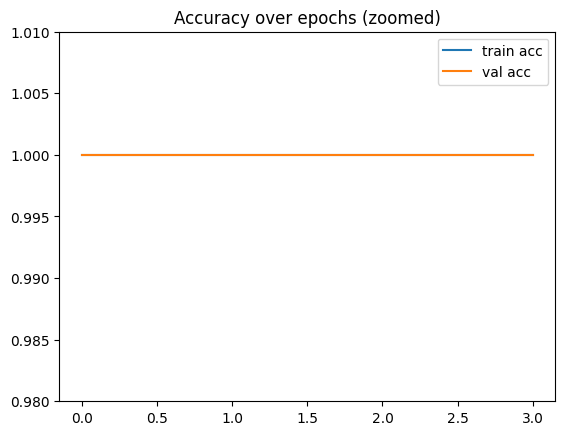

In [9]:
# visualize training history
import matplotlib.pyplot as plt

plt.plot(custom_history.history["accuracy"], label="train acc")
plt.plot(custom_history.history["val_accuracy"], label="val acc")
plt.ylim([0.98, 1.01])
plt.title("Accuracy over epochs (zoomed)")
plt.legend()
plt.show()

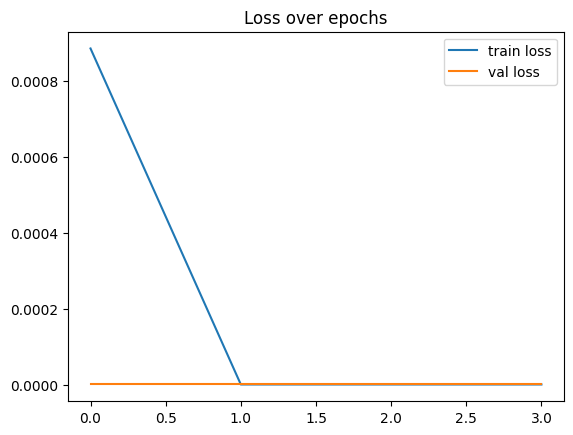

In [10]:
plt.plot(custom_history.history["loss"], label="train loss")
plt.plot(custom_history.history["val_loss"], label="val loss")
plt.title("Loss over epochs")
plt.legend()
plt.show()

# playing around with pretrained VGG-16 and layering on top of it

In [11]:
# Load VGG-16 without the top (fully connected) layers
def build_vgg_model():
    from tensorflow.keras.applications import VGG16
    from tensorflow.keras.models import Model
    from tensorflow.keras.layers import Flatten, Dense, Dropout, Input

    base_model = VGG16(
        weights="imagenet",
        include_top=False,
        input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
    )

    # Freeze all layers so we don't train them (yet)
    for layer in base_model.layers:
        layer.trainable = False

    x = Flatten()(base_model.output)
    x = Dense(256, activation="relu")(x)
    x = Dropout(0.5)(x)
    outputs = Dense(2, activation="softmax")(x)

    # Confirm the number of layers and their trainable status
    print(f"Total layers: {len(base_model.layers)}")
    print(f"Trainable layers: {sum([layer.trainable for layer in base_model.layers])}")

    return Model(inputs=base_model.input, outputs=outputs)


Classifier put on top of pretrained VGG-16 base:

Flatten final convolutional features

Use a dense layer or two for learning dataset-specific patterns

End in a softmax because we're doing binary dog-or-cat classification

In [12]:
trained_vgg_model, vgg_history = train_model(
    model_builder=build_vgg_model,
    train_generator=train_ds,
    valid_generator=valid_ds,
    epochs=10,
)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
✅ Using 2 GPU(s)
Total layers: 19
Trainable layers: 0


2025-05-28 17:34:03.795711: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 3615 of 10000
2025-05-28 17:34:23.579848: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


Epoch 1/10
INFO:tensorflow:Collective all_reduce tensors: 4 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


2025-05-28 17:35:12.626820: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 3868 of 10000
2025-05-28 17:35:22.627743: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 8088 of 10000
2025-05-28 17:35:26.995604: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


  1/625 ━━━━━━━━━━━━━━━━━━━━ 11:17:54 65s/step - accuracy: 0.0625 - loss: 2.1426

2025-05-28 17:35:30.264087: E tensorflow/core/common_runtime/base_collective_executor.cc:248] BaseCollectiveExecutor::StartAbort INVALID_ARGUMENT: Shape mismatch in the collective instance 101. Op at device /job:localhost/replica:0/task:0/device:GPU:0 expected shape [4719362] but another member in the group expected shape [81996418]. This is likely due to different input shapes at different members of the collective op.
2025-05-28 17:35:30.286846: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17477785616819217095


InvalidArgumentError: Graph execution error:

Detected at node cond/adam/CollectiveReduceV2_1 defined at (most recent call last):
  File "/usr/local/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/local/lib/python3.10/runpy.py", line 86, in _run_code

  File "/mnt/c/Users/Nick/git/deep_learning_image_classification/.venv/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/mnt/c/Users/Nick/git/deep_learning_image_classification/.venv/lib/python3.10/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/mnt/c/Users/Nick/git/deep_learning_image_classification/.venv/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/mnt/c/Users/Nick/git/deep_learning_image_classification/.venv/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 211, in start

  File "/usr/local/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/local/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/local/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/mnt/c/Users/Nick/git/deep_learning_image_classification/.venv/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/mnt/c/Users/Nick/git/deep_learning_image_classification/.venv/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/mnt/c/Users/Nick/git/deep_learning_image_classification/.venv/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/mnt/c/Users/Nick/git/deep_learning_image_classification/.venv/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/mnt/c/Users/Nick/git/deep_learning_image_classification/.venv/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/mnt/c/Users/Nick/git/deep_learning_image_classification/.venv/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/mnt/c/Users/Nick/git/deep_learning_image_classification/.venv/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/mnt/c/Users/Nick/git/deep_learning_image_classification/.venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3077, in run_cell

  File "/mnt/c/Users/Nick/git/deep_learning_image_classification/.venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3132, in _run_cell

  File "/mnt/c/Users/Nick/git/deep_learning_image_classification/.venv/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner

  File "/mnt/c/Users/Nick/git/deep_learning_image_classification/.venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3336, in run_cell_async

  File "/mnt/c/Users/Nick/git/deep_learning_image_classification/.venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3519, in run_ast_nodes

  File "/mnt/c/Users/Nick/git/deep_learning_image_classification/.venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3579, in run_code

  File "/tmp/ipykernel_667/390868919.py", line 1, in <module>

  File "/tmp/ipykernel_667/1958587939.py", line 46, in train_model

  File "/mnt/c/Users/Nick/git/deep_learning_image_classification/.venv/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/mnt/c/Users/Nick/git/deep_learning_image_classification/.venv/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 377, in fit

  File "/mnt/c/Users/Nick/git/deep_learning_image_classification/.venv/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 220, in function

  File "/mnt/c/Users/Nick/git/deep_learning_image_classification/.venv/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 133, in multi_step_on_iterator

  File "/mnt/c/Users/Nick/git/deep_learning_image_classification/.venv/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 114, in one_step_on_data

  File "/mnt/c/Users/Nick/git/deep_learning_image_classification/.venv/lib/python3.10/site-packages/keras/src/optimizers/loss_scale_optimizer.py", line 254, in _handle_cross_replica

  File "/mnt/c/Users/Nick/git/deep_learning_image_classification/.venv/lib/python3.10/site-packages/keras/src/ops/core.py", line 1041, in cond

  File "/mnt/c/Users/Nick/git/deep_learning_image_classification/.venv/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/mnt/c/Users/Nick/git/deep_learning_image_classification/.venv/lib/python3.10/site-packages/keras/src/ops/core.py", line 995, in __call__

  File "/mnt/c/Users/Nick/git/deep_learning_image_classification/.venv/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/mnt/c/Users/Nick/git/deep_learning_image_classification/.venv/lib/python3.10/site-packages/keras/src/ops/core.py", line 987, in call_fn

  File "/mnt/c/Users/Nick/git/deep_learning_image_classification/.venv/lib/python3.10/site-packages/keras/src/ops/core.py", line 1001, in call

  File "/mnt/c/Users/Nick/git/deep_learning_image_classification/.venv/lib/python3.10/site-packages/keras/src/backend/tensorflow/core.py", line 256, in cond

  File "/mnt/c/Users/Nick/git/deep_learning_image_classification/.venv/lib/python3.10/site-packages/keras/src/optimizers/loss_scale_optimizer.py", line 245, in apply_fn

Collective ops is aborted by: Shape mismatch in the collective instance 101. Op at device /job:localhost/replica:0/task:0/device:GPU:0 expected shape [4719362] but another member in the group expected shape [81996418]. This is likely due to different input shapes at different members of the collective op.
The error could be from a previous operation. Restart your program to reset.
	 [[{{node cond/adam/CollectiveReduceV2_1}}]] [Op:__inference_multi_step_on_iterator_56902]

### Evaluate VGG-based model

In [ ]:
from tensorflow.keras.models import load_model

best_model = load_model("checkpoints/best_model.keras")
results = best_model.evaluate(valid_ds)
print(f"Validation accuracy: {results[1]:.4f}")


In [ ]:
# visualize training history
import matplotlib.pyplot as plt

plt.plot(vgg_history.history["accuracy"], label="train acc")
plt.plot(vgg_history.history["val_accuracy"], label="val acc")
plt.ylim([0.98, 1.01])
plt.title("Accuracy over epochs (zoomed)")
plt.legend()
plt.show()


In [ ]:
plt.plot(vgg_history.history["loss"], label="train loss")
plt.plot(vgg_history.history["val_loss"], label="val loss")
plt.title("Loss over epochs")
plt.legend()
plt.show()

In [ ]:
trained_vgg_model.save("models/final_model.keras")